Import packages.

In [1]:
import time
import numpy                   as np
import matplotlib.pyplot       as plt
from sklearn.cluster           import KMeans
from sklearn.metrics           import pairwise_distances
from matplotlib                import cm

In [2]:
from MREC import *

Dataset.

In [3]:
n_pts_per_clus = 2*1000

In [4]:
X = np.concatenate([np.random.normal(loc=0.,  scale=1., size=n_pts_per_clus)[:,np.newaxis],  
                    np.random.normal(loc=0.,  scale=1., size=n_pts_per_clus)[:,np.newaxis]], axis=1)
Y = np.concatenate([np.random.normal(loc=0.,  scale=1., size=n_pts_per_clus)[:,np.newaxis],  
                    np.random.normal(loc=10., scale=1., size=n_pts_per_clus)[:,np.newaxis]], axis=1)
Z = np.concatenate([np.random.normal(loc=30., scale=1., size=n_pts_per_clus)[:,np.newaxis],  
                    np.random.normal(loc=0.,  scale=1., size=n_pts_per_clus)[:,np.newaxis]], axis=1)

In [5]:
X1 = np.concatenate([X[:int(len(X)/2),:],Y[:int(len(Y)/2),:],Z[:int(len(Z)/2),:]], axis=0)
lab1 = np.array(  [1 for _ in range(int(len(X)/2))] 
                + [2 for _ in range(int(len(Y)/2))] 
                + [3 for _ in range(int(len(Z)/2))])
X2 = np.concatenate([X[int(len(X)/2):,:],Z[int(len(Z)/2):,:],Y[int(len(Y)/2):,:]], axis=0)
lab2 = np.array(  [1 for _ in range(int(len(X)/2))] 
                + [3 for _ in range(int(len(Z)/2))] 
                + [2 for _ in range(int(len(Y)/2))])
D1, D2 = pairwise_distances(X1), pairwise_distances(X2)

Compute matching.

In [6]:
matching        = WS 
matching_params = {"metric": "euclidean", "epsilon": 1e-2, "tol": 1e-9, "max_iter": 1000}
quant_params    = {"n_centroids":300, "method":"RandomChoice", "metric":"euclidean"}

In [ ]:
matching        = WS 
matching_params = {"metric": "euclidean", "epsilon": 1e-2, "tol": 1e-9, "max_iter": 1000}
quant_params    = {"n_centroids":-1, "method":None, "metric":"euclidean"}

In [ ]:
matching        = GWS 
matching_params = {"epsilon": 1e-3, "tol": 1e-9, "max_iter": 1000}
quant_params    = {"n_centroids":50, "method":"RandomChoice", "metric":"precomputed"}

In [ ]:
matching        = MXS 
matching_params = {"metric": "euclidean", "alpha": .8, "epsilon": 1e2, "tol": 1e-9, "max_iter": 1000}
quant_params    = {"n_centroids":50, "method":"RandomChoice", "metric":"euclidean"}

In [ ]:
matching        = GWNC
matching_params = {"num_iter":15,"sigma_m_0":5.,"mu":10.,"method":"L-BFGS-B","map_init":None,"verbose":False}
quant_params    = {"n_centroids":50, "method":"RandomChoice", "metric":"precomputed"}

In [ ]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [ ]:
matching        = GWC_sdpnal
matching_params = {"eng": eng, "use_birkhoff": False}
quant_params    = {"n_centroids":50, "method":"RandomChoice", "metric":"precomputed"}

In [ ]:
matching        = GWC_cplex
matching_params = {"eng": eng, "maxtime": 10}
quant_params    = {"n_centroids":50, "method":"RandomChoice", "metric":"precomputed"}

In [7]:
start = time.time()
gamma, mapping = MREC(X1=X1, X2=X2, D1=None, D2=None, D1quant=D1, D2quant=D2, return_gamma=True,
                 matching=matching, 
                 matching_params=matching_params, 
                 quant_params=quant_params, 
                 threshold=10)
end = time.time()
quality = 0
for i in range(len(mapping)):
    labs, labt = lab1[i], lab2[mapping[i]]
    if labs == labt:
        quality += 1
quality /= len(mapping)
distortion = distortion_score(X1=X1, X2=X2, gamma=gamma, computation="3", metric="euclidean")
print(quality, distortion, end-start)

1.0 0.35879008768013904 1.6807763576507568


Plot matching.

<IPython.core.display.Javascript object>


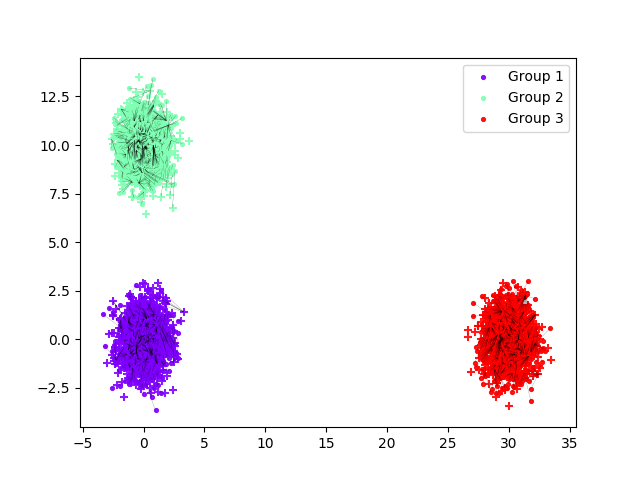

In [8]:
%matplotlib notebook

plt.figure()
labname = {1: "Group 1", 2: "Group 2", 3: "Group 3"}
clrmap = cm.get_cmap("rainbow")
ML, mL = max(lab1), min(lab1)
for i in np.unique(lab1):
    I1, I2 = np.argwhere(lab1==i)[::1,0], np.argwhere(lab2==i)[::1,0]
    plt.scatter(X1[I1,0], X1[I1,1], c=clrmap((i-mL)/(ML-mL)), marker=".", s=30, alpha=.9, label=labname[i])
    plt.scatter(X2[I2,0], X2[I2,1], c=clrmap((i-mL)/(ML-mL)), marker="+", s=30, alpha=.9)
    for j in I1:
        plt.plot([X1[j,0], X2[mapping[j],0]], [X1[j,1], X2[mapping[j],1]], c="black", linewidth=.1)
plt.legend()
plt.show()